In [20]:
import numpy as np
import matplotlib.pyplot as plt
# import glob
from scipy.fft import rfftfreq, rfft, irfft
from grand import ECEF, Geodetic, GRANDCS, LTP
from scipy.optimize import minimize_scalar

plt.style.use("/Users/xishui/Dropbox/Config/presentation.mplstyle")

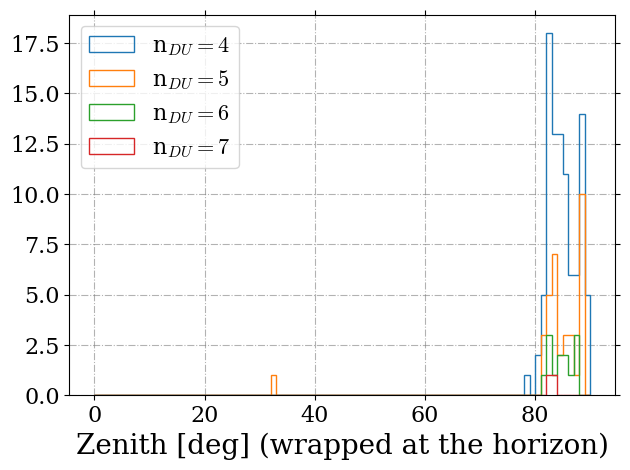

In [10]:
rec_PWF = np.genfromtxt("conincidence_table/GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_plane_wave_recons.txt")

zenith_wrapped_around_horizon = rec_PWF[:,2].copy()
zenith_wrapped_around_horizon = 180 - zenith_wrapped_around_horizon
zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] = 90 - (zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] - 90)
# plt.hist(zenith_wrapped_around_horizon, bins=np.linspace(70, 90, 201), label='Total', histtype='step', lw=3, color='k')
plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 4], bins=np.linspace(0, 90, 91), label='n$_{DU}=4$', histtype='step', lw=1)
plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 5], bins=np.linspace(0, 90, 91), label='n$_{DU}=5$', histtype='step', lw=1)
plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 6], bins=np.linspace(0, 90, 91), label='n$_{DU}=6$', histtype='step', lw=1)
plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 7], bins=np.linspace(0, 90, 91), label='n$_{DU}=7$', histtype='step', lw=1)

plt.legend()
plt.xlabel('Zenith [deg] (wrapped at the horizon)')
plt.grid()
# plt.xlim(70, 90)
# plt.xticks(np.arange(0, 91, 10))
plt.tight_layout()
plt.legend(loc='best')
# plt.savefig("imgs/zenith_dist_beacon_173.pdf");

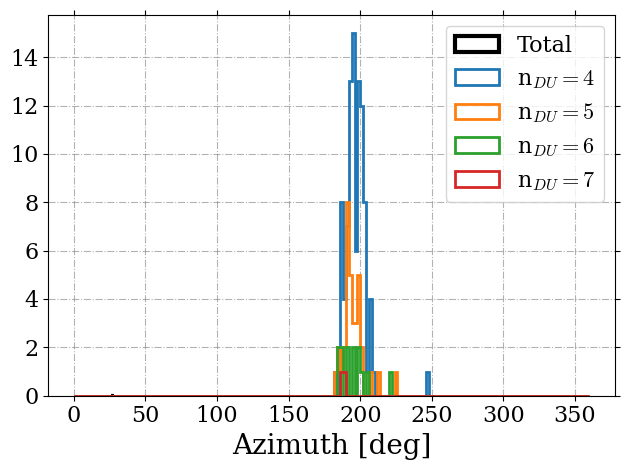

In [16]:
# change the coordinate system: "from source to observer" to "from observer to source"
# the conventional CR notation
azimuth = rec_PWF[:,4] + 180
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
plt.hist(azimuth, bins=np.linspace(26, 28, 101), label='Total', histtype='step', lw=3, color='k')
plt.hist(azimuth[rec_PWF[:,1] == 4], bins=np.linspace(0, 360, 181), label='n$_{DU}=4$', histtype='step', lw=2)
plt.hist(azimuth[rec_PWF[:,1] == 5], bins=np.linspace(0, 360, 181), label='n$_{DU}=5$', histtype='step', lw=2)
plt.hist(azimuth[rec_PWF[:,1] == 6], bins=np.linspace(0, 360, 181), label='n$_{DU}=6$', histtype='step', lw=2)
plt.hist(azimuth[rec_PWF[:,1] == 7], bins=np.linspace(0, 360, 181), label='n$_{DU}=7$', histtype='step', lw=2)
plt.legend()
plt.xlabel("Azimuth [deg]")
# plt.xlim(26, 28)
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/azimuth_dist_beacon_173.pdf")

In [17]:
file_coinctable = np.genfromtxt("conincidence_table/GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_coinctable.txt", dtype=float)
file_ducoord = np.genfromtxt("conincidence_table/GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/coord_antennas.txt", dtype=float)
file_rec_sphere = np.genfromtxt("conincidence_table/GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_sphere_wave_recons.txt", dtype=float, usecols=np.arange(9))
file_rec_plane = np.genfromtxt("conincidence_table/GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_plane_wave_recons.txt", dtype=float)

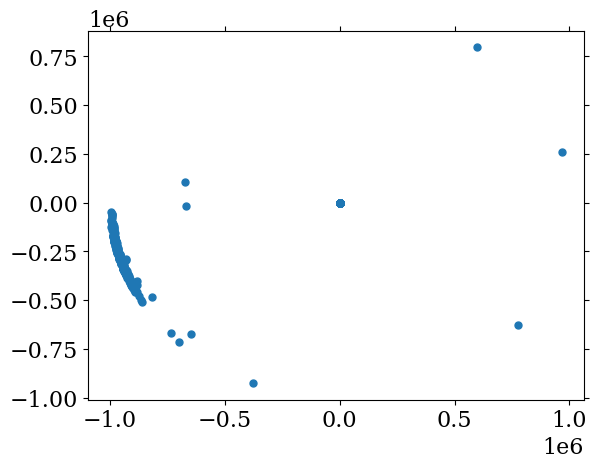

In [32]:
plt.plot(file_rec_sphere[:,4], file_rec_sphere[:,5], marker='.', ls='')

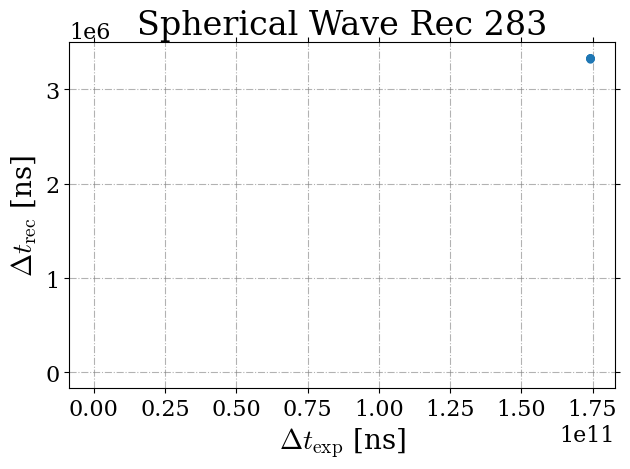

In [18]:
for event_id in rec_PWF[:,0][rec_PWF[:,1] == 6]:
# event_id = [1] # the time of trace
  list_linenumber = file_coinctable[file_coinctable[:,1] == event_id,0]
  time_delay_exp = file_coinctable[file_coinctable[:,1] == event_id][:,2]
  mask_sort_time_delay = np.argsort(time_delay_exp)
  rec_pos_source = file_rec_sphere[file_rec_sphere[:,0] == event_id,4:7].flatten() # Reconstructed position of the source
  time_offset = file_rec_sphere[file_rec_sphere[:,0] == event_id,7] / 3e8 * 1e9
  du_pos = file_ducoord[list_linenumber.astype("int"),1:]
  time_delay_rec = np.sqrt(np.sum((du_pos - rec_pos_source)**2, axis=1)) / 3e8 * 1e9 # in nanoseconds
  plt.clf()
  plt.plot(time_delay_exp[mask_sort_time_delay] * 1e9, time_delay_rec[mask_sort_time_delay] + time_offset, marker='.', ls='')
  plt.plot([0, 2000], [0, 2000], ls='--', color='r')
  plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
  plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
  plt.title(f"Spherical Wave Rec {event_id:.0f}")
  plt.grid(True)
  plt.tight_layout()
  # plt.savefig(f"imgs/delay_spherical_{event_id}_5DU.pdf")

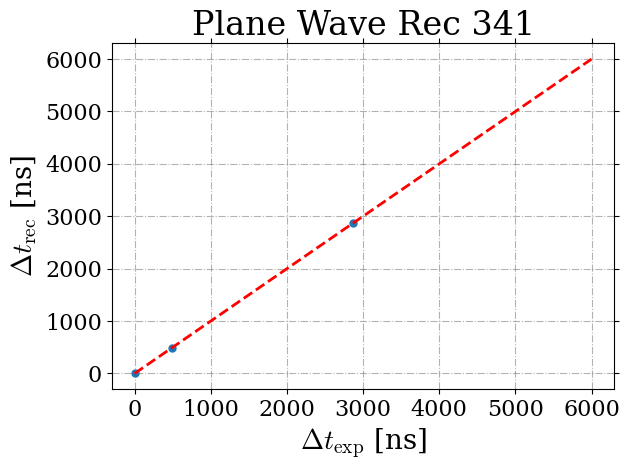

In [31]:
list_chi2 = np.zeros(len(rec_PWF))
for i, event_id in enumerate(file_rec_plane[:,0]):
  list_linenumber = file_coinctable[file_coinctable[:,1] == event_id,0]
  time_delay_exp = file_coinctable[file_coinctable[:,1] == event_id,2]
  time_delay_exp_ns = time_delay_exp * 1e9
  time_delay_exp_ns0 = time_delay_exp_ns - time_delay_exp_ns.min()
  argmin = np.argmin(time_delay_exp_ns0)
  mask_sort_time_delay = np.argsort(time_delay_exp_ns0)

  rec_theta, rec_phi = np.radians(file_rec_plane[file_rec_plane[:,0] == event_id,[2,4]]) # Reconstructed direction of the source
  du_pos = file_ducoord[list_linenumber.astype("int"),1:]
  event_coord_shower_axis = np.dot(du_pos, [np.sin(rec_theta) * np.cos(rec_phi), np.sin(rec_theta) * np.sin(rec_phi), np.cos(rec_theta)]) 
  time_delay_rec =  event_coord_shower_axis / 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_rec[mask_sort_time_delay][argmin]
  chi2 = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_rec[mask_sort_time_delay] + time_offset))**2) / (len(time_delay_exp) - 2)
  list_chi2[i] = chi2
  plt.clf()  
  plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_rec[mask_sort_time_delay] + time_offset, marker='.', ls='')
  # plt.axis("equal")
  plt.plot(np.array([0, 6000]), np.array([0, 6000]), ls='--', color='r')
  plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
  plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
  plt.title(f"Plane Wave Rec {event_id:.0f}")
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"imgs/0616/delay_plane_{event_id:.0f}.pdf")

[]

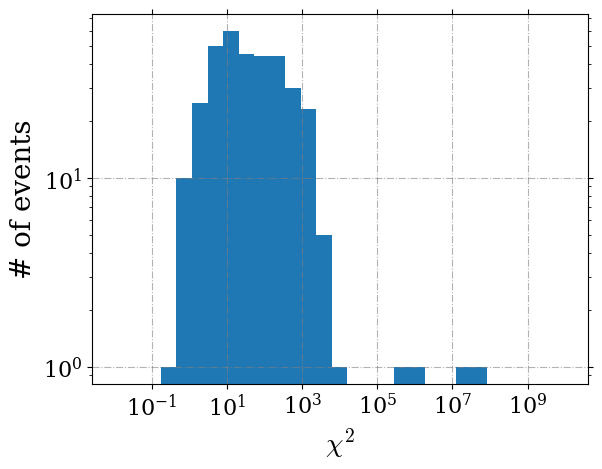

In [45]:
plt.hist(list_chi2, np.logspace(-2, 10, 30))
plt.ylabel("# of events")
plt.xlabel("$\chi^2$")
plt.grid()
plt.loglog()